# Wide Residual Networks

We explore here the pytorch implementation from [szagoruyko/wide-residual-networks](https://github.com/szagoruyko/wide-residual-networks/blob/master/pytorch/resnet.py).

## Overview

A Wide Residual Network is composed of 4 parts that produce image features that can be further classified with a fully-connected layer:
```
---[Conv3x3]-->[G1]-->[G2]-->[G3][BN][ReLU]--->[Pool]-[FC]---
```

A WRN model is configured by two parameters: depth, width (`WRN-d-w`).
Depth has to be `6 x n + 4`, where `n` defines the number blocks in the groups.
Width defines the width of residual blocks.

### Pre-act residual block

A group `Gi` is composed of `n` blocks (where `n = (depth - 4) // 6`):
```
---[A1]--[B2]--...--[Bn]---
```

The first group `A1` can have a stride equals 1 or 2 in the convolutions. Other blocks `B1`, ..., `Bn`
have stride equal 1 

a) Identity shortcut
```
                   stride=1               stride=1
---.--[BN]-[ReLU]-[Conv3x3]--[BN]-[ReLU]-[Conv3x3]--[+]---
   |                                                 | 
   |-------------------------------------------------|

```
b) Projection shortcut
```
                   stride=2                stride=1
---[BN]-[ReLU]--.--[Conv3x3]--[BN]-[ReLU]-[Conv3x3]--[+]---
                |                                     | 
                |--[Conv1x1]--------------------------|
                   stride=2
```


["Wide Residual Networks" Sergey Zagoruyko, Nikos Komodakis](https://arxiv.org/pdf/1605.07146.pdf)

In [2]:
import sys
sys.path.insert(0, "../common")

from dot import make_dot

In [3]:
!git clone https://github.com/szagoruyko/wide-residual-networks.git
!git clone https://github.com/bunbun/nested-dict

fatal: destination path 'wide-residual-networks' already exists and is not an empty directory.
fatal: destination path 'nested-dict' already exists and is not an empty directory.


In [4]:
import sys
sys.path.insert(0, "wide-residual-networks/pytorch")
sys.path.insert(0, "nested-dict")

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES']=""

In [6]:
# https://github.com/szagoruyko/wide-residual-networks/blob/master/pytorch/resnet.py

import torch
import torch.nn.functional as F
import utils


def resnet(depth, width, num_classes):
    assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
    n = (depth - 4) // 6
    widths = [int(v * width) for v in (16, 32, 64)]

    def gen_block_params(ni, no):
        return {
            'conv0': utils.conv_params(ni, no, 3),
            'conv1': utils.conv_params(no, no, 3),
            'bn0': utils.bnparams(ni),
            'bn1': utils.bnparams(no),
            'convdim': utils.conv_params(ni, no, 1) if ni != no else None,
        }

    def gen_group_params(ni, no, count):
        return {'block%d' % i: gen_block_params(ni if i == 0 else no, no)
                for i in range(count)}

    flat_params = utils.cast(utils.flatten({
        'conv0': utils.conv_params(3, 16, 3),
        'group0': gen_group_params(16, widths[0], n),
        'group1': gen_group_params(widths[0], widths[1], n),
        'group2': gen_group_params(widths[1], widths[2], n),
        'bn': utils.bnparams(widths[2]),
        'fc': utils.linear_params(widths[2], num_classes),
    }))

    utils.set_requires_grad_except_bn_(flat_params)

    def block(x, params, base, mode, stride):
        o1 = F.relu(utils.batch_norm(x, params, base + '.bn0', mode), inplace=True)
        y = F.conv2d(o1, params[base + '.conv0'], stride=stride, padding=1)
        o2 = F.relu(utils.batch_norm(y, params, base + '.bn1', mode), inplace=True)
        z = F.conv2d(o2, params[base + '.conv1'], stride=1, padding=1)
        if base + '.convdim' in params:
            return z + F.conv2d(o1, params[base + '.convdim'], stride=stride)
        else:
            return z + x

    def group(o, params, base, mode, stride):
        for i in range(n):
            o = block(o, params, '%s.block%d' % (base,i), mode, stride if i == 0 else 1)
        return o

    def f(input, params, mode):
        x = F.conv2d(input, params['conv0'], padding=1)
        g0 = group(x, params, 'group0', mode, 1)
        g1 = group(g0, params, 'group1', mode, 2)
        g2 = group(g1, params, 'group2', mode, 2)
        o = F.relu(utils.batch_norm(g2, params, 'bn', mode))
        o = F.avg_pool2d(o, 8, 1, 0)
        o = o.view(o.size(0), -1)
        o = F.linear(o, params['fc.weight'], params['fc.bias'])
        return o

    return f, flat_params

The smallest WRN-10-1, composed of groups with a single block without width expansion.

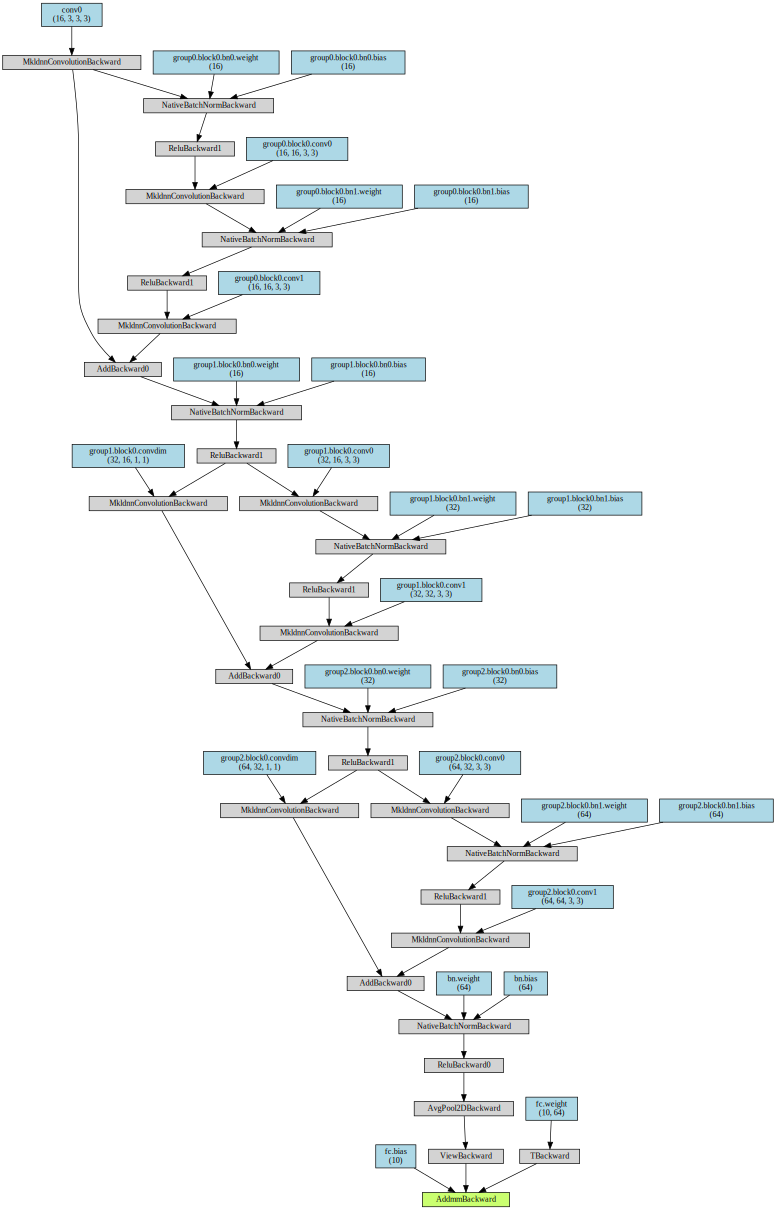

In [29]:
f, params = resnet(10, 1, 10)

x = torch.rand(2, 3, 32, 32)
y = f(x, params, mode=True)
make_dot(y, params)

In [31]:
# convert numpy arrays to torch Variables
for k,v in sorted(params.items()):
    print(k, tuple(v.shape))
    params[k] = v
    
print('\nTotal parameters:', sum(v.numel() for v in params.values()))

bn.bias (64,)
bn.running_mean (64,)
bn.running_var (64,)
bn.weight (64,)
conv0 (16, 3, 3, 3)
fc.bias (10,)
fc.weight (10, 64)
group0.block0.bn0.bias (16,)
group0.block0.bn0.running_mean (16,)
group0.block0.bn0.running_var (16,)
group0.block0.bn0.weight (16,)
group0.block0.bn1.bias (16,)
group0.block0.bn1.running_mean (16,)
group0.block0.bn1.running_var (16,)
group0.block0.bn1.weight (16,)
group0.block0.conv0 (16, 16, 3, 3)
group0.block0.conv1 (16, 16, 3, 3)
group1.block0.bn0.bias (16,)
group1.block0.bn0.running_mean (16,)
group1.block0.bn0.running_var (16,)
group1.block0.bn0.weight (16,)
group1.block0.bn1.bias (32,)
group1.block0.bn1.running_mean (32,)
group1.block0.bn1.running_var (32,)
group1.block0.bn1.weight (32,)
group1.block0.conv0 (32, 16, 3, 3)
group1.block0.conv1 (32, 32, 3, 3)
group1.block0.convdim (32, 16, 1, 1)
group2.block0.bn0.bias (32,)
group2.block0.bn0.running_mean (32,)
group2.block0.bn0.running_var (32,)
group2.block0.bn0.weight (32,)
group2.block0.bn1.bias (64,)
gro

WRN-10-2, composed of groups with a single block with width expansion.

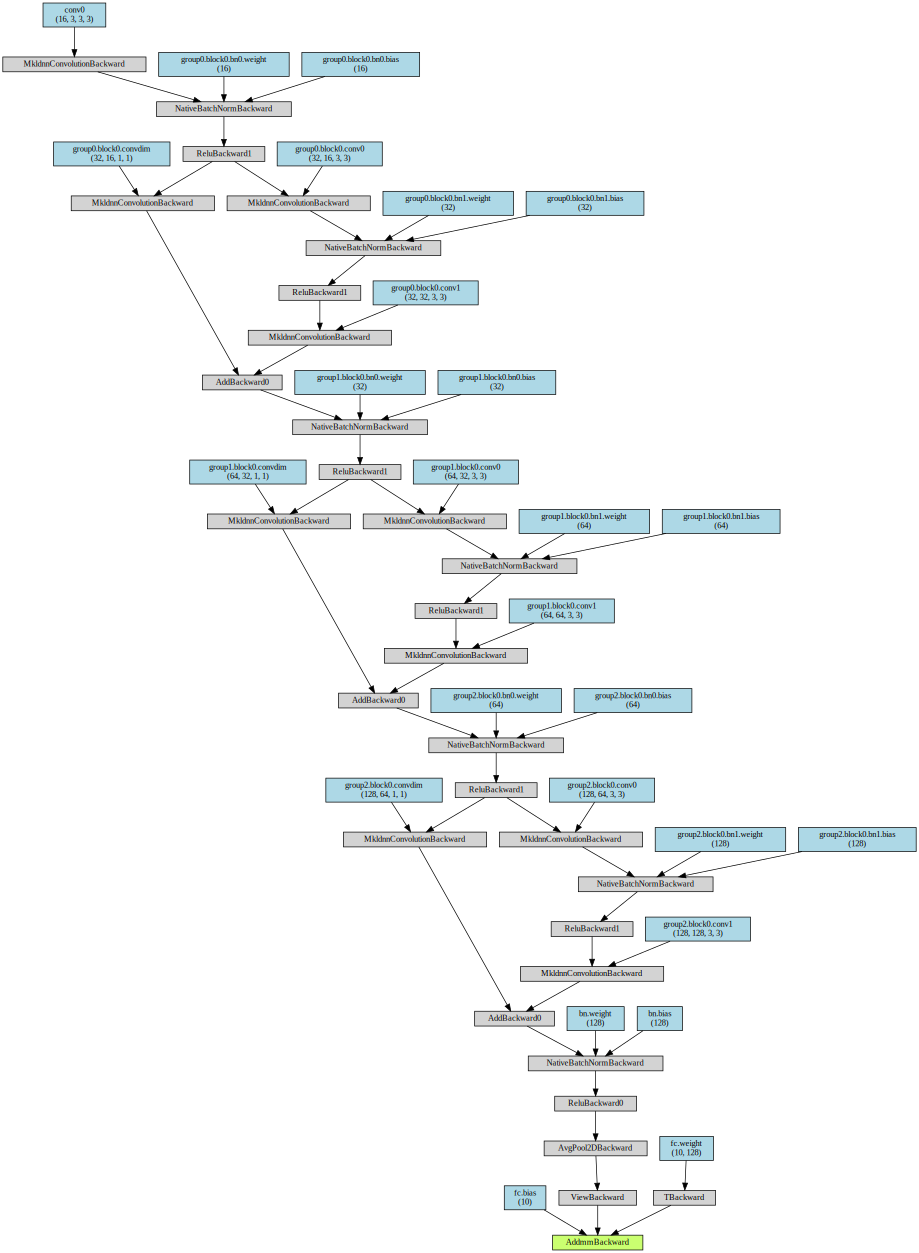

In [24]:
f, params = resnet(10, 2, 10)

x = torch.rand(2, 3, 32, 32)
y = f(x, params, mode=True)
make_dot(y, params)

WRN-16-2

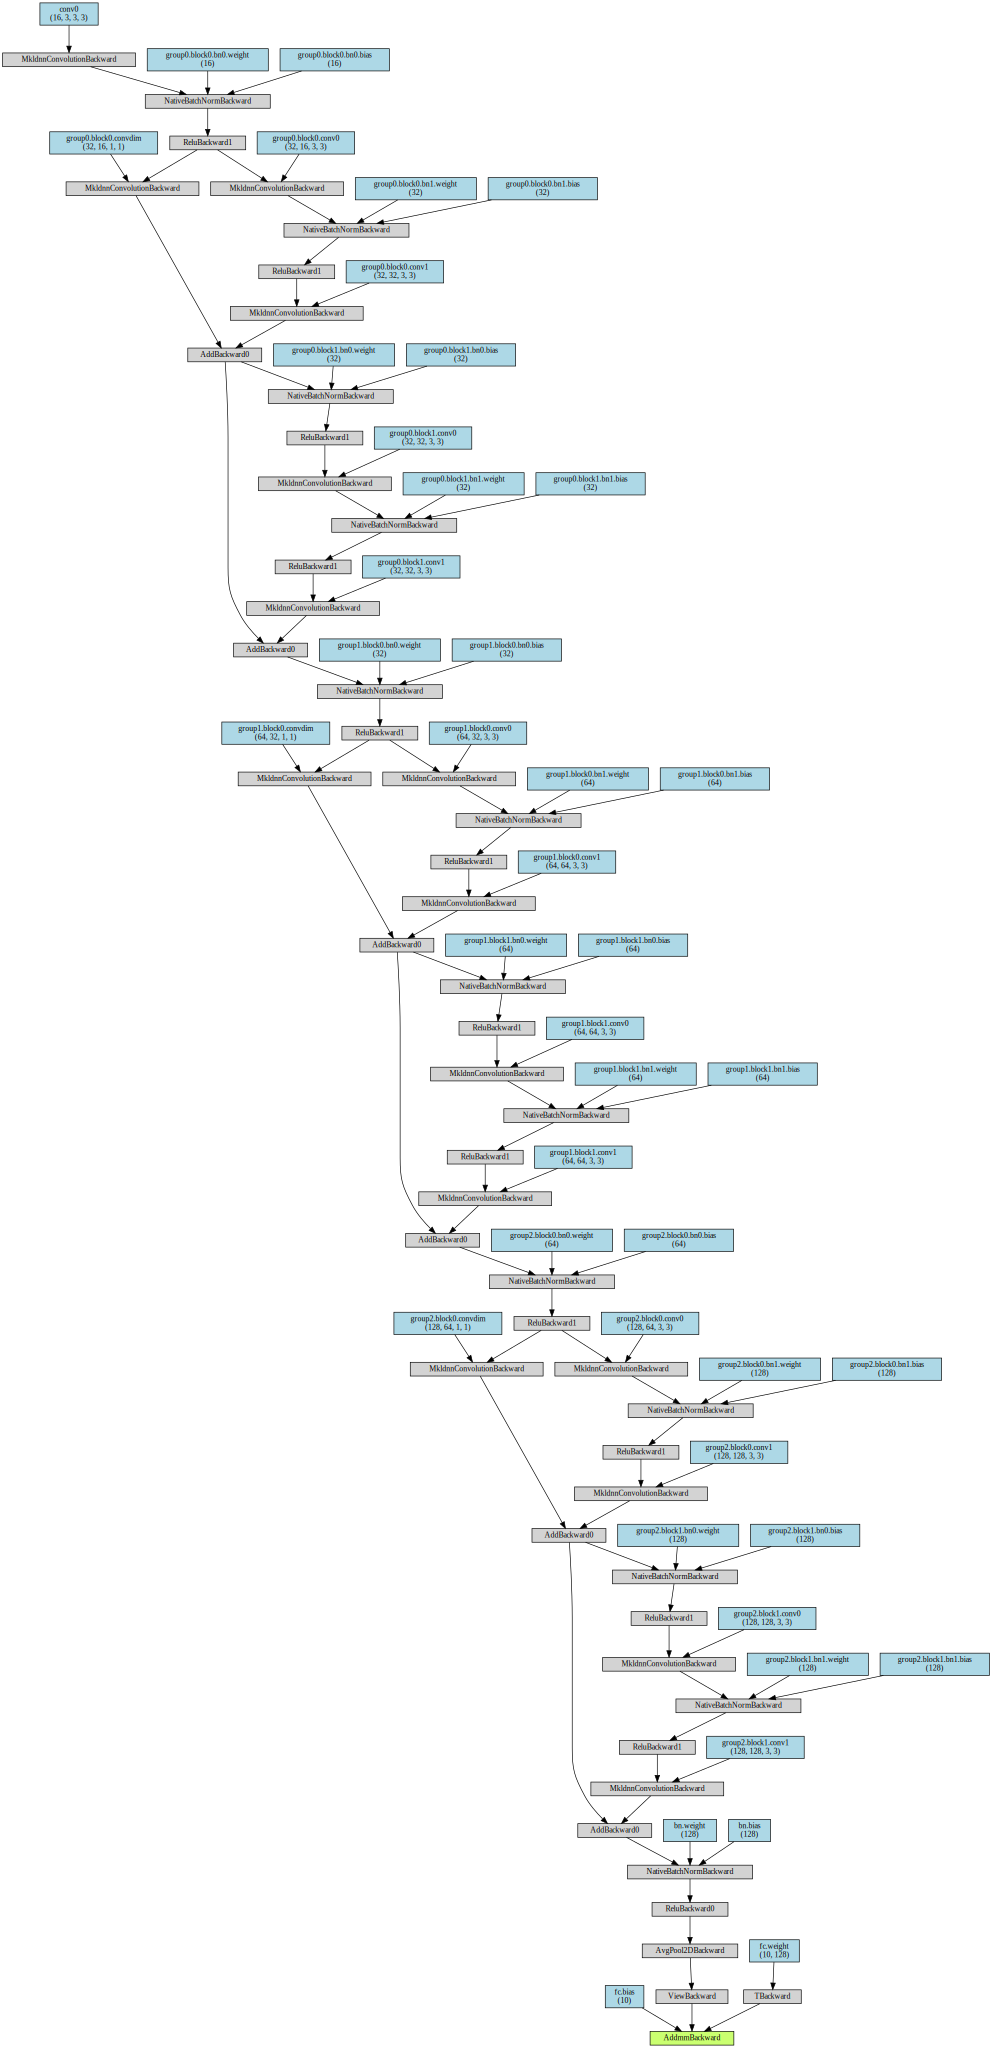

In [26]:
f, params = resnet(16, 2, 10)

x = torch.rand(2, 3, 32, 32)
y = f(x, params, mode=True)
make_dot(y, params)

In [68]:
from functools import partial

def foo(x):    
    return f(x, params, mode=True)

In [69]:
import torch

g = torch.jit.trace(foo, x)
g.graph

graph(%input.1 : Float(2, 3, 32, 32)) {
  %1 : Float(16, 3, 3, 3) = prim::Constant[value=<Tensor>]()
  %2 : Tensor = prim::Undefined()
  %3 : int = prim::Constant[value=1]()
  %4 : int = prim::Constant[value=1]()
  %5 : int[] = prim::ListConstruct(%3, %4)
  %6 : int = prim::Constant[value=1]()
  %7 : int = prim::Constant[value=1]()
  %8 : int[] = prim::ListConstruct(%6, %7)
  %9 : int = prim::Constant[value=1]()
  %10 : int = prim::Constant[value=1]()
  %11 : int[] = prim::ListConstruct(%9, %10)
  %12 : bool = prim::Constant[value=0]()
  %13 : int = prim::Constant[value=0]()
  %14 : int = prim::Constant[value=0]()
  %15 : int[] = prim::ListConstruct(%13, %14)
  %16 : int = prim::Constant[value=1]()
  %17 : bool = prim::Constant[value=0]()
  %18 : bool = prim::Constant[value=0]()
  %19 : bool = prim::Constant[value=1]()
  %input.2 : Float(2, 16, 32, 32) = aten::_convolution(%input.1, %1, %2, %5, %8, %11, %12, %15, %16, %17, %18, %19)
  %37 : Float(16) = prim::Constant[value=<Tensor>]()


Implementation with `nn.Module`

In [40]:
import torch.nn as nn


class WRNBlock(nn.Module):
    
    def __init__(self, inplanes, outplanes, stride=1, downsample=None):
        super(WRNBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(True)
        self.conv1 = nn.Conv2d(inplanes, outplanes, kernel_size=3, stride=stride, padding=1, bias=False)
        
        self.bn2 = nn.BatchNorm2d(outplanes)
        self.relu2 = nn.ReLU(True)        
        self.conv2 = nn.Conv2d(outplanes, outplanes, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        x = self.bn1(x)
        x = self.relu1(x)

        if self.downsample is not None:
            residual = self.downsample(x)

        x = self.conv1(x)
        
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv2(x)
        
        y = x + residual
        return y
        

class WRN(nn.Module):
    
    def __init__(self, depth, width, num_classes):
        assert (depth - 4) % 6 == 0, 'Depth should be 6 * n + 4'        
        super(WRN, self).__init__()        
        self.width = width
        self.depth = depth

        n = (depth - 4) // 6
        widths = [int(v * width) for v in (16, 32, 64)]

        self.prep = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        
        self.group0 = self._make_group(16, widths[0], n=n, stride=1)
        self.group1 = self._make_group(widths[0], widths[1], n=n, stride=2)
        self.group2 = self._make_group(widths[1], widths[2], n=n, stride=2)
        
        self.bn = nn.BatchNorm2d(widths[2])
        self.relu = nn.ReLU(True)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(widths[2], num_classes)        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_group(self, inplanes, outplanes, n, stride):
        downsample = None
        if stride != 1 or inplanes != outplanes:
            downsample = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, bias=False)

        layers = [WRNBlock(inplanes, outplanes, stride=stride, downsample=downsample)]
        for i in range(1, n):
            layers.append(WRNBlock(outplanes, outplanes, stride=1))

        return nn.Sequential(*layers)        
        
    def forward(self, x):
        x = self.prep(x)
        x = self.group0(x)
        x = self.group1(x)
        x = self.group2(x)                
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        y = self.fc(x)
        return y

In [118]:
model = WRN(10, 1, 10)
model.train();

x = torch.rand(2, 3, 32, 32)
y = model(x)

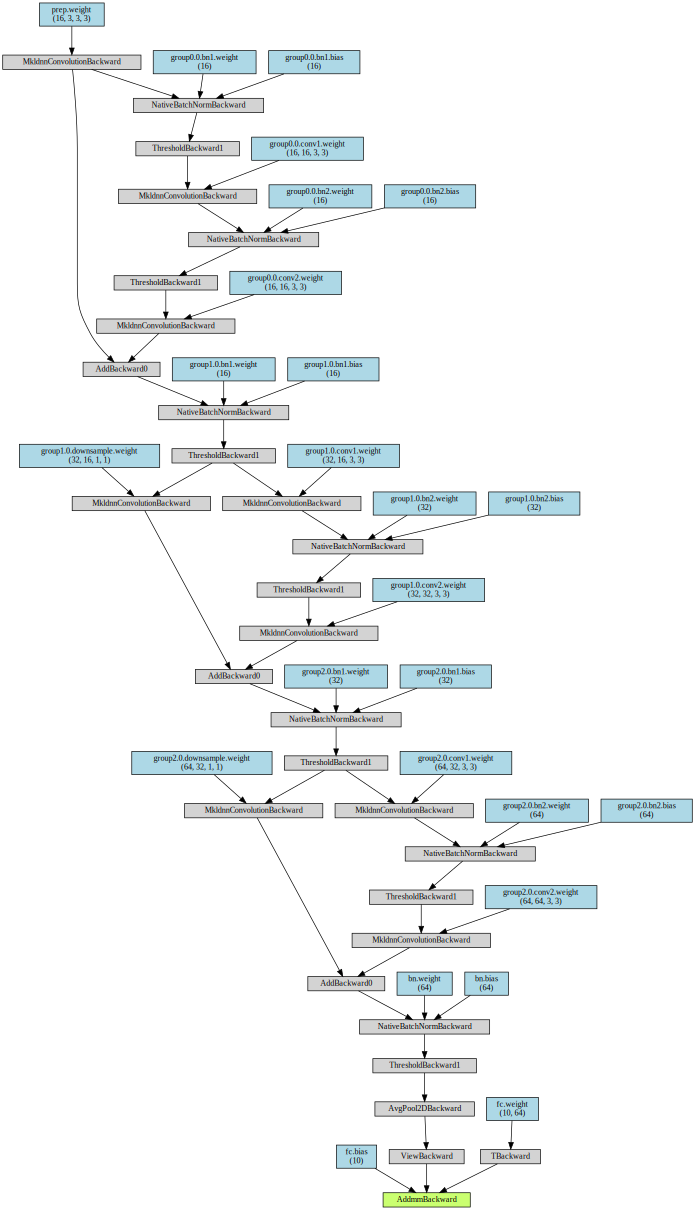

In [119]:
make_dot(y, dict(model.named_parameters()))